In [1]:
import sys
import time
import numpy as np
import math
import pandas as pd
from sklearn.utils.validation import check_X_y
from honest_forests.estimators import HonestForestClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import check_X_y
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import scipy.stats as stats
from joblib import Parallel, delayed
import copy
from tensorflow import keras

In [2]:
def Posterior_After(X,v,X_sample,tree_i):
    
    #Duplicate the sigle sample test
    X_testsample_duplicated = np.tile(X,(X_sample.shape[0],1))
    
    ### Replace test data with values from structure subset   
    X_variable = X_sample[:,v]
    
    X_testsample_duplicated[:,v] = X_variable
    X_testsample_duplicated = X_testsample_duplicated.astype(np.float32)
    
    #Obtain the possible leaves with ignoring variable v
    leaves_indicies = np.unique(tree_i.tree_.apply(X_testsample_duplicated)) 
    value_leaves = np.sum(tree_i.tree_.value[leaves_indicies], axis=0)
    
    #Calculate the posterior probability for sample x
    
    posterior_proba = value_leaves/np.sum(value_leaves) 
    
    
    return value_leaves,posterior_proba
    
    

In [3]:
def SCORE(tree_i,X,y):
    X_structure = X[tree_i.structure_indices_]
    X_honest = X[tree_i.honest_indices_]
    y_honest  = y[tree_i.honest_indices_]
        
    leaves_indicies_before = tree_i.tree_.apply(X_honest.astype(np.float32))
    value_leaves_before = tree_i.tree_.value[leaves_indicies_before]
    classification_before = np.zeros(X_honest.shape[0])
    #error_before = np.zeros((X_honest.shape[0],1))
        
    posterior_proba_before = np.zeros((X_honest.shape[0],3))##n_classes
    value_leaves = np.zeros((X_honest.shape[0],3))
    posterior_proba = np.zeros((X_honest.shape[0],3))
    classification_after = np.zeros(X_honest.shape[0])
    difference_clf = np.zeros(X_honest.shape[0])
    #error_after = np.zeros((X_honest.shape[0],1))
        
    mean_diff = np.zeros(X_honest.shape[1])
    feature_org = pd.unique(tree_i.tree_.feature)
    feature = feature_org[feature_org>=0]
    #print(feature)
    for k in feature:
        #print(k)
        # posterior_proba_before = np.divide(value_leaves_before,np.sum(value_leaves_before,axis = 1))
        # print(posterior_proba_before)
        #value_leaves,posterior_proba = pd.DataFrame(X_honest).apply(Posterior_After,args = (k,X_structure,tree_i),axis = 1)

        for i in range(0,X_honest.shape[0]):
            ##Compute posterior probability before merging
            posterior_proba_before[i,:] = value_leaves_before[i,:]/np.sum(value_leaves_before[i,:])
            ##Compute posterior probability after merging
            value_leaves[i,:],posterior_proba[i,:] = Posterior_After(X_honest[i,:],k,X_structure,tree_i)
            #Compute the difference of posterior possibility for just one class
            
        ## Get the classification_before result
        classification_before = posterior_proba_before.argmax(1)
        #print(classification_before)
        ## Get the classification_after result
        classification_after = posterior_proba.argmax(1)
            
        #Calculate classification error before 
        error_before = np.mean(np.abs(y_honest - classification_before))
        #Calculate classification error after merging leaves
        error_after = np.mean(np.abs(y_honest - classification_after))
        #Calculate the difference of classification error
        difference_clf = error_after - error_before
        mean_diff[k] = difference_clf
    return mean_diff

In [4]:
def Permutation(X,y,CLASSIFIER):
    Y_predict_before = CLASSIFIER.predict(X)
    predict_error = np.mean(np.abs(Y_predict_before-y))
    feature = []
    for tree_i in CLASSIFIER.estimators_:
        feature_org_i = pd.unique(tree_i.tree_.feature)
        feature_i = feature_org_i[feature_org_i>=0]
        feature = pd.unique([int(x) for x in pd.unique(np.append(feature,feature_i))])
    permutation_score = np.zeros(X.shape[1])
    for k in feature:
        #print(k)
        score_k = []
        for i in range(0,5):
            #print(X[:,k])
            X_k = copy.copy(X)
            #print(X_k)
            X_k[:,k] = shuffle(X[:,k])
            #print(X_k[:,k])
            #print(X[:,k])
            Y_predict_after = CLASSIFIER.predict(X_k)
            predict_error_after = np.mean(np.abs(Y_predict_after-y))
            #print(predict_error_after)
            score_k = np.append(score_k,predict_error_after-predict_error)
        permutation_score[k] = np.mean(score_k)
    print(permutation_score)
    return permutation_score
            


Whether we could split pictures with segment, rather than pixle.

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train/255.0
nsamples, nx, ny, nrgb = x_train.shape
x_train2 = x_train.reshape((nsamples,nx*ny*nrgb))

x_test = x_test/255.0
nsamples_test, nx_test, ny_test, nrgb_test = x_test.shape
x_test2 = x_test.reshape((nsamples_test,nx_test*ny_test*nrgb_test))

In [6]:
X_train_total = x_train2[np.argwhere(y_train<3)[:,0],:]
y_train_total = y_train[np.argwhere(y_train<3)[:,0],:]
print(y_train_total.shape)



X_test_total = x_test2[np.argwhere(y_test<3)[:,0],:]
y_test_total = y_test[np.argwhere(y_test<3)[:,0],:]
print(y_test_total.shape)

(15000, 1)
(3000, 1)


In [7]:
np.geomspace(625, 25, num=3,dtype = int)

array([625, 125,  25])

In [8]:
N = 5
d = 32*32*3
n_estimator = 100
samples_space = np.geomspace(625, 5, num=4, dtype=int)
ERROR_hf = np.zeros((3,N))
ERROR_rf = np.zeros((3,N))
TIC_HFIM = []
TIC_HFP = []
TIC_RFP = []
SCORE_HFIM= np.zeros([3,N,d])
SCORE_HFP= np.zeros([3,N,d])
SCORE_RFP= np.zeros([3,N,d])
n_sample = 0
for sample_size_i in samples_space[1:]:
    print(sample_size_i)
    error = [] 
    error_rf = []

    score_hf = np.zeros((N,d))## HFIM
    #Calculter Permutation Based HF socre
    score_hfp = np.zeros((N,d))## Permutation FIM with honest forest

    #Calculter Permutation Based RF socre
    score_rfp = np.zeros((N,d))
    TIC_1 = []
    TIC_2 = []
    TIC_3 = []
    for num in range(0,N):
        print(num)
        Data = shuffle(np.hstack([X_train_total, y_train_total]))
        nsample2 = X_train_total.shape[0]
        #print(nsample2)
        X_train = Data[np.arange(0,nsample2,3*sample_size_i),0:-1]
        Y_train = Data[np.arange(0,nsample2,3*sample_size_i),-1].ravel()
        print(X_train.shape[0])
        #print(y_train)

        Data_test = shuffle(np.hstack([X_test_total, y_test_total]))
        nsample_test2 = X_test_total.shape[0]
        X_test = Data_test[np.arange(0,nsample_test2,1),0:-1]
        Y_test = Data_test[np.arange(0,nsample_test2,1),-1].ravel()

        #Train an Honest Tree
        ###We find that the honest tree nust be full trained？
        ###there will be difference for the rank of feature imporatnces  
        #t_ht = time.time()
        tic_hf = time.perf_counter()
        clf = HonestForestClassifier(honest_fraction = 0.1, 
                                    n_estimators = n_estimator,
                                    #max_depth = 20,
                                    max_features = d,bootstrap = False)
        clf = clf.fit(X_train, Y_train)

        print("finish")
        toc_hf = time.perf_counter()
        y_predict = clf.predict(X_test)
        indicator = [0 if Y_test[i] == y_predict[i] else 1 for i in range(len(Y_test))]
        predict_error = np.mean(indicator)
        error = np.append(error,predict_error)
        print(toc_hf-tic_hf)
        print("finish")
        print("prediction error" + str(predict_error))

        tic_1 = time.perf_counter()
        score_tree = np.zeros((n_estimator,d))
        num_tree = 0
        
        for tree_i in clf.estimators_:
            
            score_tree_i = SCORE(tree_i,X_train,Y_train)
            score_tree[num_tree,:] = score_tree_i
            num_tree = num_tree+1
            #print(num_tree)

        #Save HF socre
        score_hf[num,:] = np.mean(score_tree,axis = 0)
        toc_1 = time.perf_counter()
        print("TIME_HF " + str(toc_1-tic_1))
        TIC_1.append(toc_hf-tic_hf + toc_1-tic_1)

        
        tic_2 = time.perf_counter()
        r_hf = Permutation(X_train,Y_train,clf)
        score_hfp[num,:] = r_hf
        toc_2 = time.perf_counter()
        print("TIME_HFP " + str(toc_2-tic_2))
        TIC_2.append(toc_hf-tic_hf + toc_2-tic_2)
        
        
        tic_rf = time.perf_counter()
        clf_rf = RandomForestClassifier(n_estimators = n_estimator,max_features = d,bootstrap = False)
        clf_rf = clf_rf.fit(X_train, Y_train)
        toc_rf = time.perf_counter()
        print("finish")
        y_predict_rf = clf_rf.predict(X_test)
        indicator_rf = [0 if Y_test[i] == y_predict_rf[i] else 1 for i in range(len(Y_test))]
        predict_error_rf = np.mean(indicator_rf)
        error_rf = np.append(error_rf,predict_error_rf)

        print("finish")
        print("prediction error" + str(predict_error_rf))
        
        tic_3 = time.perf_counter()
        r_rf = Permutation(X_train,Y_train,clf_rf)
        score_rfp[num,:] = r_rf
        toc_3 = time.perf_counter()
        print("TIME_RF " + str(toc_rf-tic_rf))
        print("TIME_RFP " + str(toc_3-tic_3))
        TIC_3.append(toc_rf-tic_rf + toc_3-tic_3)
        num += 1
    
    SCORE_HFIM[n_sample,:,:] = score_hf
    SCORE_HFP[n_sample,:,:] = score_hfp
    SCORE_RFP[n_sample,:,:] = score_rfp
    
    
    TIC_HFIM.append(np.mean(TIC_1))
    TIC_HFP.append(np.mean(TIC_2))
    TIC_RFP.append(np.mean(TIC_3))

    ERROR_hf[n_sample,:] = error
    ERROR_rf[n_sample,:] = error_rf
    n_sample +=1

print(ERROR_hf.shape)
print(ERROR_rf.shape)
    
    

125
0
40
finish
2.2101101899999946
finish
prediction error0.569
TIME_HF 0.4114904139999851
[0. 0. 0. ... 0. 0. 0.]
TIME_HFP 21.88908773099999
finish
finish
prediction error0.567
[0. 0. 0. ... 0. 0. 0.]
TIME_RF 2.573749900999985
TIME_RFP 11.603350946999996
1
40
finish
2.056185011999986
finish
prediction error0.6263333333333333
TIME_HF 0.4077773969999896
[0. 0. 0. ... 0. 0. 0.]
TIME_HFP 25.041705089999994
finish
finish
prediction error0.591
[0. 0. 0. ... 0. 0. 0.]
TIME_RF 2.0746349510000073
TIME_RFP 10.827999144999978
2
40
finish
2.1121416310000143
finish
prediction error0.5863333333333334
TIME_HF 0.4027253620000124
[0. 0. 0. ... 0. 0. 0.]
TIME_HFP 22.937950979999982
finish
finish
prediction error0.525
[0. 0. 0. ... 0. 0. 0.]
TIME_RF 2.3047999959999856
TIME_RFP 11.91748941100002
3
40
finish
1.9192725350000046
finish
prediction error0.44766666666666666
TIME_HF 0.34069604300003675
[0. 0. 0. ... 0. 0. 0.]
TIME_HFP 17.169776343000024
finish
finish
prediction error0.44466666666666665
[0. 0. 0

In [27]:
ERROR_hf

array([[0.654     , 0.551     , 0.59866667, 0.543     , 0.61833333],
       [0.422     , 0.37033333, 0.39466667, 0.39733333, 0.35966667],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [33]:
print(np.mean(error))
ci_er_low,ci_er_up = stats.t.interval(0.95, N-1, loc=np.mean(error,axis = 0), scale=stats.sem(error,axis = 0))
print(ci_er_low)
print(ci_er_up)

0.3433666666666667
0.3346014405653778
0.35213189276795565


In [34]:
print(np.mean(error_rf))
ci_er_low,ci_er_up = stats.t.interval(0.95, N-1, loc=np.mean(error_rf,axis = 0), scale=stats.sem(error_rf,axis = 0))
print(ci_er_low)
print(ci_er_up)

0.45723333333333327
0.4445616380765687
0.46990502859009786


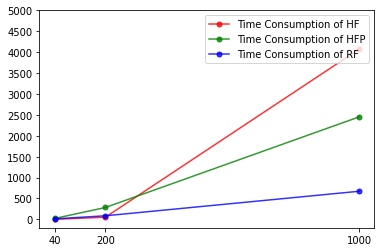

In [24]:
x_axis = 5000/np.geomspace(625, 5, num=4, dtype=int)[1:]
plt.plot(x_axis,TIC_HFIM,'r',marker='o',alpha = 0.8,markersize=5,label = 'Time Consumption of HF')
plt.plot(x_axis,TIC_HFP,'g',marker='o',alpha = 0.8,markersize=5,label = 'Time Consumption of HFP')
plt.plot(x_axis,TIC_RFP,'b',marker='o',alpha = 0.8,markersize=5,label = 'Time Consumption of RF')
plt.yticks(np.arange(0,5500,500))
plt.xticks(x_axis)
plt.legend(loc = 'upper right')
plt.show()

[0.19295492 0.02908664 0.04915693]
[0.1385337  0.06571415 0.02423702]


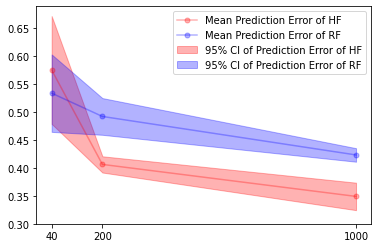

In [10]:

ERROR_MEAN = np.mean(ERROR_hf,axis = 1)
ci_error_hf_low,ci_error_hf_up = stats.t.interval(0.95, N-1, loc=np.mean(ERROR_hf,axis = 1), scale=stats.sem(ERROR_hf,axis = 1))
# score_hf_mean[idx]=0
# ci_hf_low[idx] = 0
x_axis = 5000/np.geomspace(625, 5, num=4, dtype=int)[1:]
plt.plot(x_axis,ERROR_MEAN,'r',marker='o',alpha = 0.3,markersize=5,label = 'Mean Prediction Error of HF')
plt.fill_between(x_axis,ci_error_hf_low,ci_error_hf_up,alpha = 0.3,color = 'red',label = '95% CI of Prediction Error of HF')
width_hf = ci_error_hf_up-ci_error_hf_low
print(width_hf)

ERROR_MEAN = np.mean(ERROR_rf,axis = 1)
ci_error_rf_low,ci_error_rf_up = stats.t.interval(0.95, N-1, loc=np.mean(ERROR_rf,axis = 1), scale=stats.sem(ERROR_rf,axis = 1))
# score_hf_mean[idx]=0
# ci_hf_low[idx] = 0
x_axis = 5000/np.geomspace(625, 5, num=4, dtype=int)[1:]
plt.plot(x_axis,ERROR_MEAN,'b',marker='o',alpha = 0.3,markersize=5,label = 'Mean Prediction Error of RF')
plt.fill_between(x_axis,ci_error_rf_low,ci_error_rf_up,alpha = 0.3,color = 'blue',label = '95% CI of Prediction Error of RF')
width_rf = ci_error_rf_up-ci_error_rf_low
print(width_rf)
plt.yticks(np.arange(0.30,0.70,0.05))
plt.xticks(x_axis)
plt.legend()
plt.show()

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


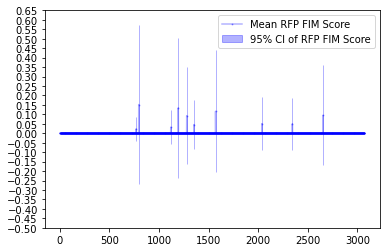

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


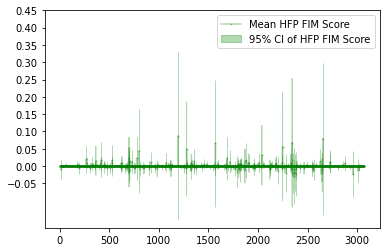

0


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


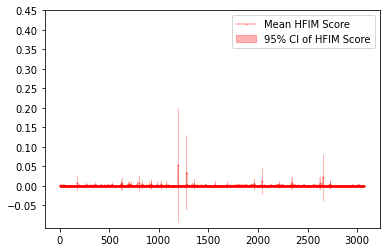

1


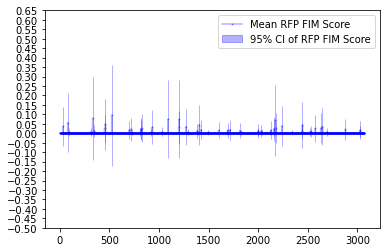

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


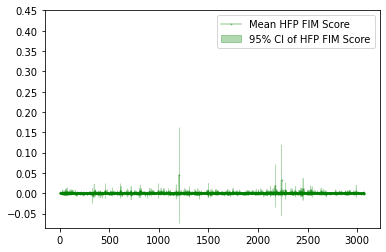

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


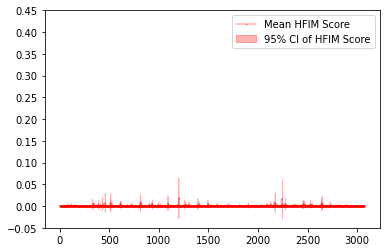

2


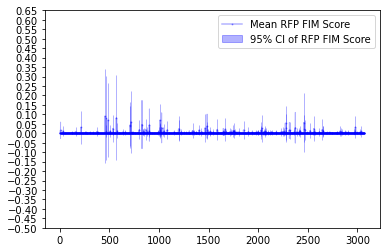

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


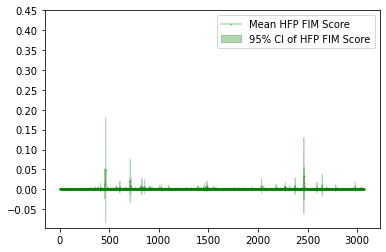

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


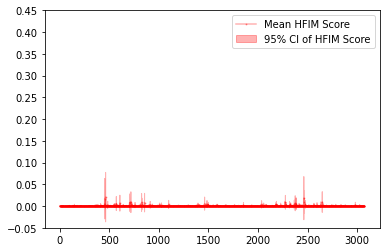

In [25]:
d_plt = d
for i in range(0,3):
    #plt.figure().set_figheight(6)
    print(i)
    score_rfp = SCORE_RFP[i,:,:]
    score_rfp_mean = np.mean(score_rfp[:,0:d_plt],axis = 0)
    ci_rfp_low,ci_rfp_up = stats.t.interval(0.95, N-1, loc=np.mean(score_rfp[:,0:d_plt],axis = 0), scale=stats.sem(score_rfp[:,0:d_plt],axis = 0))
    # score_hf_mean[idx]=0
    # ci_hf_low[idx] = 0
    # ci_hf_up[idx] = 0
    plt.plot(np.arange(1,d_plt+1,1),score_rfp_mean,'b',marker='o',alpha = 0.3,markersize=1,label = 'Mean RFP FIM Score')
    plt.fill_between(np.arange(1,d_plt+1,1),ci_rfp_low,ci_rfp_up,alpha = 0.3,color = 'blue',label = '95% CI of RFP FIM Score')
    # width_hf = np.mean(ci_hf_up-ci_hf_low)
    # print("average width of 95% CI of HFIM Score is " + str(width_hf))
    #plt.xticks(np.arange(1,d_plt))
    plt.yticks(np.arange(-0.5,0.7,0.05))

    plt.legend()
    plt.show()

    score_hfp = SCORE_HFP[i,:,:]
    score_hf_mean = np.mean(score_hfp[:,0:d_plt],axis = 0)
    ci_hf_low,ci_hf_up = stats.t.interval(0.95, N-1, loc=np.mean(score_hfp[:,0:d_plt],axis = 0), scale=stats.sem(score_hfp[:,0:d_plt],axis = 0))
    # score_hf_mean[idx]=0
    # ci_hf_low[idx] = 0
    # ci_hf_up[idx] = 0
    plt.plot(np.arange(1,d_plt+1,1),score_hf_mean,'g',marker='o',alpha = 0.3,markersize=1,label = 'Mean HFP FIM Score')
    plt.fill_between(np.arange(1,d_plt+1,1),ci_hf_low,ci_hf_up,alpha = 0.3,color = 'green',label = '95% CI of HFP FIM Score')
    # width_hf = np.mean(ci_hf_up-ci_hf_low)
    # print("average width of 95% CI of HFIM Score is " + str(width_hf))
    #plt.xticks(np.arange(1,d_plt,128))
    plt.yticks(np.arange(-0.05,0.5,0.05))
    plt.legend()
    plt.show()
   
    score_hf = SCORE_HFIM[i,:,:]
    score_hf_mean = np.mean(score_hf[:,0:d_plt],axis = 0)
    ci_hf_low,ci_hf_up = stats.t.interval(0.95, N-1, loc=np.mean(score_hf[:,0:d_plt],axis = 0), scale=stats.sem(score_hf[:,0:d_plt],axis = 0))
    # score_hf_mean[idx]=0
    # ci_hf_low[idx] = 0
    # ci_hf_up[idx] = 0
    plt.plot(np.arange(1,d_plt+1,1),score_hf_mean,'r',marker='o',alpha = 0.3,markersize=1,label = 'Mean HFIM Score')
    plt.fill_between(np.arange(1,d_plt+1,1),ci_hf_low,ci_hf_up,alpha = 0.3,color = 'red',label = '95% CI of HFIM Score')
    # width_hf = np.mean(ci_hf_up-ci_hf_low)
    # print("average width of 95% CI of HFIM Score is " + str(width_hf))
    #plt.xticks(np.arange(1,d_plt,128))
    plt.yticks(np.arange(-0.05,0.5,0.05))
    plt.legend()
    plt.show()


In [1]:
depth_HF = []
for tree_i in clf.estimators_:
    depth_HF.append(tree_i.get_depth())
print(depth_HF)
print(np.mean(depth_HF))
print(stats.mode(depth_HF))


depth_RF = []
for tree_i in clf_rf.estimators_:
    depth_RF.append(tree_i.get_depth())
print(depth_RF)
print(np.mean(depth_RF))
print(stats.mode(depth_RF))

NameError: name 'clf' is not defined